In [1]:
# 코랩을 사용하지 않으면 이 셀의 코드를 주석 처리하세요.
!git clone https://github.com/rickiepark/nlp-with-transformers.git
%cd nlp-with-transformers
from install import *
install_requirements(chapter=2)

Cloning into 'nlp-with-transformers'...
remote: Enumerating objects: 653, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 653 (delta 47), reused 15 (delta 8), pack-reused 569
Receiving objects: 100% (653/653), 62.41 MiB | 18.47 MiB/s, done.
Resolving deltas: 100% (335/335), done.
/content/nlp-with-transformers
⏳ Installing base requirements ...
✅ Base requirements installed!
Using transformers v4.35.2
Using datasets v2.15.0
Using accelerate v0.25.0
Using sentencepiece v0.1.99
Using umap v0.5.5


# 2. 텍스트 분류
##### 텍스트 분류는 NLP에서 일반적인 작업이다. 고객 피드백을 어떤 카테고리로 분류하거나 언어에 따른 다른 처리를 하는 작업 등 매우 다양한 어플리케이션에 사용한다.
##### 또 다른 일반적인 텍스트 분류 작업은 감성 분석이다. 주어진 텍스트의 감성 상태를 식별하는 것이 목적이다.
##### 이 장에서는 BERT의 한 종류인 DistilBERT를 사용해 감성 상태를 인식하는 시스템을 다룰 것이다. 이 모델은 BERT에 비견할만한 성능을 내지만 훨씬 작고 효율적이다.
##### 만약 대규모 BERT 모델을 훈련해야 한다면 간단히 사전 훈련된 모델의 **체크포인트**를 바꾸면 된다.

* 체크포인트 : 트랜스포머 아키텍처로 로드되는 일련의 가중치

##### 또, 해당 예제에서 허깅페이스 생태계의 핵심 라이브러리인 데이터셋, 토크나이저, 트랜스포머스를 사용해보자
##### 원시 데이터에서 시작해 새로운 트윗에서 추론을 수행하는 미세 튜닝된 모델을 만들어보자
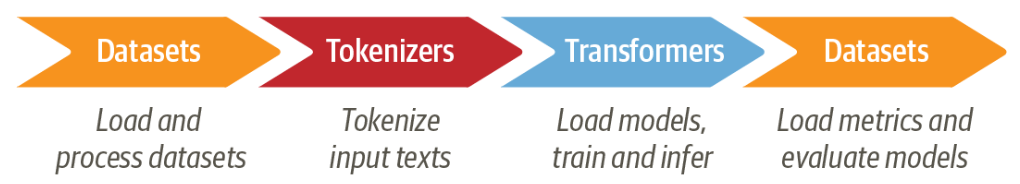

## 2.1 데이터셋
##### 감정 감지기를 개발하기 위해 영어로 작성된 트위터 메시지에 감정이 어떻게 표현되는지 연구한 논문의 데이터셋을 사용한다.
##### 이 데이터셋은 분노(anger), 혐오(disgust), 두려움(fear), 기쁨(joy), 슬픔(sadness), 놀람(surprise)의 여섯 개 감정으로 나뉜다. 트윗이 주어지면 여섯 개의 감정 중 하나로 분류하는 모델을 훈련을 진행한다.

### 2.1.1 허깅페이스 데이터셋 처음 사용하기


In [2]:
from datasets import list_datasets

all_datasets = list_datasets()
print(f"현재 허브에는 {len(all_datasets)}개의 데이터셋이 있습니다.")
print(f"처음 10개 데이터셋 {all_datasets[:10]}")

<ipython-input-2-a4e058fa2927>:3: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  all_datasets = list_datasets()


현재 허브에는 88222개의 데이터셋이 있습니다.
처음 10개 데이터셋 ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa',
'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue',
'ajgt_twitter_ar', 'allegro_reviews']


In [3]:
from datasets import load_dataset

emotions = load_dataset("emotion")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [4]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [5]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

##### 이는 Dataset 클래스 객체를 반환한다. Dataset 객체는 데이터셋의 핵심 데이터 구조 중 하나다.
##### 평범한 파이썬 배열이나 리스트처럼 동작한다.

In [6]:
len(train_ds)

16000

In [7]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [8]:
train_ds.column_names

['text', 'label']

##### 이 딕셔너리의 값은 트윗과 감정에 해당한다. 이는 허깅페이스 데이터셋이 아파치 에로우를 기반으로 한다는 것이다.
* 아파치 에로우 : 기본 파이썬보다 훨씬 더 메모리 효율적인 열 기반 포맷
##### 사용 중인 데이터 타입은 Dataset 객체의 features 속성에 표시된다.

In [9]:
 print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness',
'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [10]:
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so
damned hopeful just from being around someone who cares and is awake', 'im
grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic
about the fireplace i will know that it is still on the property', 'i am feeling
grouchy'], 'label': [0, 0, 3, 2, 3]}


### 허브에 필요한 데이터셋 없다면 ?
##### 포맷에 따라 데이터셋 로딩 방법이 아래와 같다.
##### csv, text, json -> load_dataset("csv" or "text" or "json", data_files = "my_files.csv" or "my_files.txt" or "my_files.json")

In [11]:
dataset_url = "https://huggingface.co/datasets/transformersbook/emotion-train-split/raw/main/train.txt"
!wget {dataset_url}

--2023-12-21 07:42:33--  https://huggingface.co/datasets/transformersbook/emotion-train-split/raw/main/train.txt
Resolving huggingface.co (huggingface.co)... 13.35.7.38, 13.35.7.57, 13.35.7.5, ...
Connecting to huggingface.co (huggingface.co)|13.35.7.38|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1658616 (1.6M) [text/plain]
Saving to: ‘train.txt’

train.txt           100%[===================>]   1.58M  1.63MB/s    in 1.0s    

2023-12-21 07:42:35 (1.63 MB/s) - ‘train.txt’ saved [1658616/1658616]



In [12]:
!head -n 1 train.txt

i didnt feel humiliated;sadness


In [13]:
emotions_local = load_dataset("csv", data_files="train.txt", sep=";",
                              names=["text", "label"])

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [14]:
dataset_url = "https://huggingface.co/datasets/transformersbook/emotion-train-split/raw/main/train.txt"
emotions_remote = load_dataset("csv", data_files=dataset_url, sep=";",
                               names=["text", "label"])

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

### 2.1.2 데이터셋에서 데이터프레임으로
##### 허깅페이스의 저수준 기능을 사용해서 데이터를 분석해도 되지만, 판다스의 DataFrame으로 출력 포맷을 변경하여 처리도 가능하다.

In [15]:
import pandas as pd

emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [16]:
def label_int2str(row):
  # int2str : 정수 레이블을 클래스 이름으로 바꿔주는 메서드 / str2int도 존재
  return emotions['train'].features["label"].int2str(row)

df["label_name"] = df['label'].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


### 2.1.3 클래스 분포 살펴보기
##### 텍스트 분류 문제를 다룰 때는 샘플의 클래스 분포를 조사해야 한다. 만약 클래스 분포가 편향된 데이터셋은 훈련 손실과 평가 지표 측면에서 균형 잡힌 데이터셋과 다른 처리법이 필요하다.

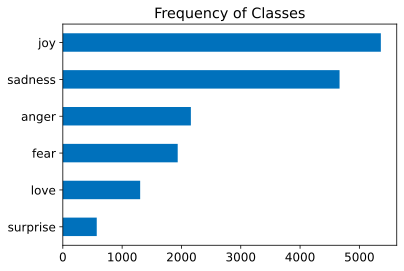

In [17]:
import matplotlib.pyplot as plt

df['label_name'].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

##### 데이터셋이 불균형하다. 데이터셋이 불균형할 때, 아래와 같은 방법으로 다룬다.
##### * 소수 클래스를 랜덤하게 오버샘플링 진행
##### * 다수 클래스를 랜덤하게 언더샘플링 진행
##### * 클래스의 대표성이 부족하다면 레이블링된 데이터를 더 많이 수집

##### 이 장에서는 간단하게 불균형한 클래스 분포를 그대로 사용할 것이다.
##### 샘플링 기법을 사용할 때는 훈련 세트에만 사용해야 한다. 그렇지 않으면 훈련/테스트 분할 사이에 많은 정보가 빠져나간다.

* 샘플링 기법 : imbalanced-learn 라이브러리 참고

### 2.1.4 트윗 길이 확인
##### 트랜스포머 모델은 **최대 문맥 크기**라는 최대 입력 시퀀스 길이가 있다.
##### DistilBERT를 사용하는 어플리케이션에서 최대 문맥 크기는 512 토큰으로 문단 몇 개 정도가 된다.
##### 토큰은 텍스트의 기본 단위이고, 여기서는 토큰을 단어로 간주한다.

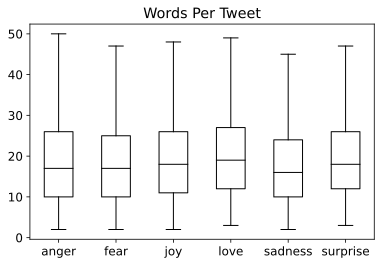

In [18]:
df['Words Per Tweet'] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False,
           color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

##### 그래프를 보면 각 감정의 트윗 길이는 15개 단어 정도이고, 가장 긴 트윗도 50개 정도이다. 텍스트가 모델의 문맥 크기보다 길면 짤라야 하는데 다행이도 해당 데이터셋은 그럴 필요가 없다.
##### 이제 원시 텍스트를 허깅페이스 트랜스포머스에 적합한 포맷으로 변경하자
##### 더 이상 DataFrame 포맷이 필요하지 않으니 데이터셋의 출력 포맷을 초기화하자

In [19]:
emotions.reset_format()

## 2.2 텍스트에서 토큰으로
##### DistilBERT 같은 트랜스포머 모델은 원시 문자열을 입력으로 받지 못한다. 대신 텍스트가 토큰화되어 수치 벡터로 인코딩 되었다고 해보자
* 토큰화 : 문자열을 모델이 사용하는 기본 단위로 분할하는 단계

##### 적용할 수 있는 토큰화 전략이 몇 가지 있으며 단어를 부분 단위로 나누기 위한 최적 분할은 일반적으로 말뭉치에서 학습된다. 문자 토큰화와 단어 토큰화를 살펴본 후 DistilBERT에서 사용하는 토크나이저에 대해 알아보자

### 2.2.1 문자 토큰화
##### 가장 간단한 토큰화는 각 문자를 개별로 모델에 주입하는 것이다.

In [20]:
text = "Tokenizing text is a core task of NLP."
tokenized_text = list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ',
'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o',
'f', ' ', 'N', 'L', 'P', '.']


##### 각 문자를 정수로 변환시키는 **수치화** 작업을 수행한다.
##### 가장 손쉬운 방법은 고유한 각 토큰을 고유한 정수로 인코딩하는 것이다.

In [21]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9,
'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18,
'z': 19}


##### 이를 통해 어휘사전에 있는 각 문자를 고유한 정수로 바꾸는 매핑 딕셔너리를 만들자
##### 이제 token2idx를 사용해 토큰화된 텍스트를 정수 리스트로 변환한다.

In [22]:
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7,
14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]


##### 각 토큰이 고유한 숫자 식별자로 매핑되었다. 마지막 단계로 input_ids를 원-핫 벡터의 2D 텐서로 바꾼다.
* 원-핫 벡터 : 머신러닝에서 순서형 또는 명목형 범주 데이터를 인코딩하기 위해 자주 사용된다.

In [23]:
categorical_df = pd.DataFrame(
    {"Name": ["Bumblebee", "Optimus Prime", "Megatron"], "Label ID": [0,1,2]})
categorical_df

,Name,Label ID
0,Bumblebee,0
1,Optimus Prime,1
2,Megatron,2


##### 이 방식은 이름 사이에 가상의 순서가 만들어진다는 문제가 있다. 신경망은 이런 종류의 관계를 학습하는 능력이 뛰어나다
##### 따라서 이 대신 범주마다 새 열을 만들어 이름이 범주에 해당하면 1, 아니면 0을 할당하자.
##### 판다스에 get_dummies() 활용

In [24]:
pd.get_dummies(categorical_df['Name'])

,Bumblebee,Megatron,Optimus Prime
0,1,0,0
1,0,0,1
2,0,1,0


##### 해당 DataFrame의 행이 원-핫 벡터이다.
##### 다음처럼 파이토치로 input_ids를 텐서로 바꾸고 one_hot() 함수를 사용해 원-핫 인코딩을 만들어보자

In [25]:
import torch
import torch.nn.functional as F

input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))
one_hot_encodings.shape

torch.Size([38, 20])

##### 38개의 입력 토큰에 각각에 20차원의 원-핫 벡터가 만들어졌다. 어휘사전을 구성하는 고유한 문자가 20개이기 때문이다.
##### ont_hot() 함수에서 num_classes 매개변수를 지정하는 것이 중요하다! 원-핫 벡터가 어휘사전보다 더 짧아질 수도 있기 때문이다. -> 텐서플로는 tf.one_hot() depth

In [26]:
print(f"토큰: {tokenized_text[0]}")
print(f"텐서 인덱스: {input_ids[0]}")
print(f"원-핫 인코딩: {one_hot_encodings[0]}")

토큰: T
텐서 인덱스: 5
원-핫 인코딩: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


##### 문자 수준의 토큰화는 텍스트의 구조를 무시하고 전체 문자열을 문자 스트림으로 처리한다. 해당 방식은 철자 오류나 희귀한 단어를 처리하는데 유용하다.
##### 하지만, 단어 같은 언어 구조를 해당 데이터에서 학습해야 하고, 큰 리소스가 든다.
##### 실제로 문자 수준의 토큰화는 잘 사용되지 않고, 텍스트의 구조를 유지할 수 있는 **단어 토큰화**를 많이 사용한다.

### 2.2.2 단어 토큰화
##### 텍스트를 문자가 아닌 단어로 분할하고 각 단어를 정수로 매핑한다. -> 훈련 과정의 복잡도 감소

In [27]:
tokenized_text = text.split()
print(tokenized_text)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']


##### 구두점이 고려되지 않아서 NLP.이 하나의 토큰으로 처리된다. 단어에 곡용, 활용형, 철자 오류가 포함되어 어휘사전이 금세 수백만 개까지 늘어날 수 있다.
##### 어휘사전이 크면 신경망의 파라미터 역시 많이 필요해져 문제가 된다.
##### 예를 들어, 100만 개의 고유한 단어가 있고, 이 100만 차원의 입력 벡터를 신경망의 첫 번째 층에서 1000차원의 벡터로 압축한다고 가정하자. 그럼 첫 번째 층의 가중치 행렬은 100만개 X 1000개 = 10억 개의 가중치를 가진다.
##### 모델 파라미터가 낭비되는건 피해야 한다. -> 어휘사전의 크기를 제한하자 -> 자주 등장하지 않는 단어들은 UNK 토큰으로 매핑하자 -> 토큰화 과정에서 중요한 정보를 잃어버릴 수도 있다.
##### 모든 입력 정보와 일부 입력 구조를 유지하는 문자 토큰화와 단어 토큰화를 절충하는 방법인 **부분단어 토큰화**를 사용하자!

### 2.2.3 부분단어 토큰화
##### 부분단어 토큰화는 기본적으로 문자 토큰화와 단어 토큰화의 장점을 결합한 방법이다.
##### 드물게 등장하는 단어를 더 작은 단위로 나누면 모델이 복잡한 단어나 철자 오류를 처리하기 용이하다.
##### 다른 한편으로는 입력 길이를 적절한 크기로 유지하기 위해 자주 등장하는 단어를 고유한 항목으로 유지한다.
##### 부분단어 토큰화는 통계 규칙과 알고리즘을 함께 사용해 사전 훈련 말뭉치에서 학습한다.

##### NLP 분야에서 널리 사용되는 부분단어 토큰화 중 먼저 BERT와 DistilBERT의 토크나이저로 사용된 WordPiece를 사용해보자

In [28]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

##### AutoTokenizer 클래스는 체크포인트 이름을 사용해 모델의 설정, 사전 훈련된 가중치, 어휘 사전을 자동으로 추출해주는 '자동 클래스'이다.
##### 이 클래스를 사용하면 모델 간의 빠른 전환이 가능하지만, 특정 클래스를 수동으로 로드할 수도 있다.

In [29]:
from transformers import DistilBertTokenizer

distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

##### * 처음 메서드를 실행하면 허깅페이스 허브에서 로딩하는 과정을 보여주는 진행 줄이 나타난다. 그러나 두번째 실행부터는 캐시로부터 토크나이저를 로드한다. 보통 캐시 위치는 ~/.cache/huggingface 이다

In [30]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953,
2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


##### attention_mask 필드의 역할은 다음 절에서 소개한다.
##### 일단, input_ids가 있으므로 토크나이저의 convert_ids_to_tokens() 메서드를 사용해 토큰으로 변환하자

In [31]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl',
'##p', '.', '[SEP]']


##### 정리
##### 1. 특수 토큰 [CLS]와 [SEP]가 끝에 추가 되었다. 이런 토큰은 모델마다 다르지만 주요 역할은 시퀀스의 시작과 끝을 의미한다.
##### 2. 토큰이 모두 소문자로 변경되었다.
##### 3. 'tokenizing'과 'NLP'가 각각 두 개의 토큰으로 나뉘었다. #은 앞의 문자열이 공백이 아님을 의미한다.

In [32]:
# 접두사가 붙은 토큰은 문자열과 함께 합친다.
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


In [33]:
# 어휘사전의 크기
print(tokenizer.vocab_size)

30522


In [34]:
# 모델의 최대 문맥 크기
print(tokenizer.model_max_length)

512


In [35]:
# 필드 이름
print(tokenizer.model_input_names)

['input_ids', 'attention_mask']


##### 사전 훈련된 모델을 사용할 때, 모델 훈련에 사용한 것과 동일한 토크나이저를 사용하는 것이 정말 중요하다.

### 2.2.4 전체 데이터셋 토큰화하기
##### 전체 말뭉치를 토큰화하기 위해 DatasetDict 객체의 map() 메서드를 사용하자.

In [36]:
def tokenize(batch):
  return tokenizer(batch["text"], padding=True, truncation=True)

##### 이 함수는 토크나이저를 샘플 배치에 적용한다.
##### padding=True로 지정하면 배치에 있는 가장 긴 샘플 크기에 맞춰 샘플을 0으로 패딩한다.
##### truncation=True로 설정하면 모델의 최대 문맥 크기에 맞춰 샘플을 잘라낸다.

In [37]:
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0,
0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000,
2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300,
102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
1, 1]]}


##### 결과
##### input_ids의 첫 번째 원소가 두 번째보다 더 짧으므로, 길이를 동일하게 맞추기 위해 끝에 0을 추가했다. 0은 어휘사전에 있는 [PAD] 토큰에 해당한다.
##### 토크나이저는 인코딩된 트윗을 input_ids로 반환하고, attention_mask 배열 리스트도 반환한다. 추가된 패딩 토큰 때문에 모델이 혼동하지 않게 하는 조치이다.
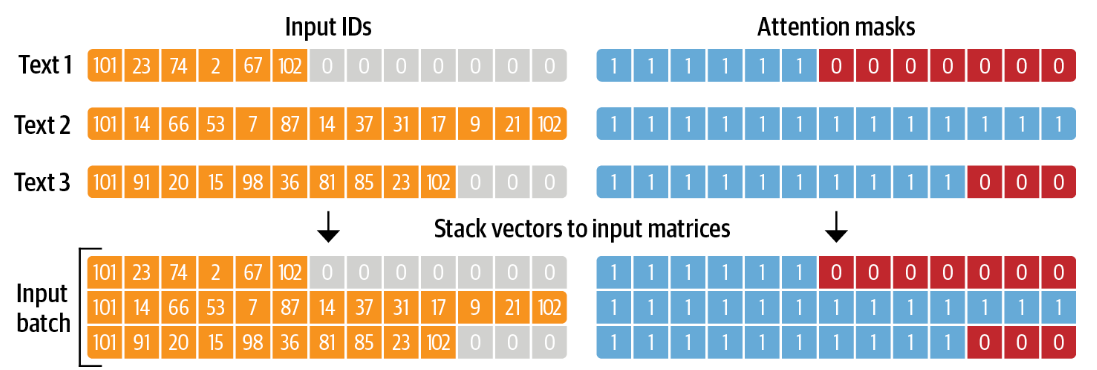

In [38]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

##### 기본적으로 map() 메서드는 말뭉치에 있는 모든 샘플에 개별적으로 적용하므로, batched=True로 설정하여 트윗을 배치로 인코딩한다.
##### 그리고 batch_size=None으로 설정했기 때문에 전체 데이터셋이 하나의 배치로 tokenize() 함수에 적용된다. 이렇게 하면 입력 텐서와 어텐션 마스크는 전역적으로 동일한 크기로 생성된다. 또 해당 연산은 데이터셋에 input_ids와 attention_maks 열을 새로 추가한다.

In [39]:
print(emotions_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


## 2.3 텍스트 분류 모델 훈련하기
##### DistilBERT 같은 모델은 텍스트 시퀀스에 있는 마스킹된 단어를 예측하도록 사전 훈련된 모델이다. 하지만 이런 언어 모델을 바로 텍스트 분류에 사용하지 못한다.
##### 특정한 수정을 가해야 하는데, 인코더 기반 모델의 구조를 보면서 알아보자.
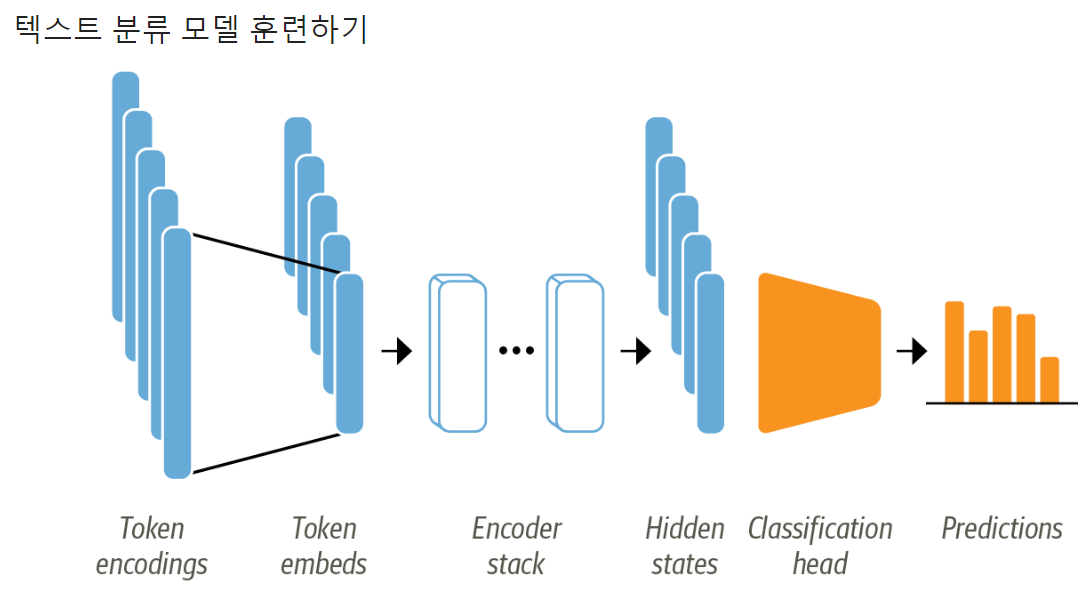

##### 먼저 텍스트를 토큰화해 토큰 인코딩이라 부르는 원-핫 벡터로 나타낸다. 토크나이저 어휘사전의 크기가 토큰 인코딩의 차원을 결정하는데, 보통 2만~2백만 개의 고유 토큰으로 구성된다.
##### 그 다음 토큰 인코딩을 저차원 공간의 벡터인 토큰 임베딩으로 변환한다. 그 다음 토큰 임베딩을 인코더 블록 층에 통과시켜 각 입력 토큰에 대한 은닉 상태를 만든다
##### 각 은닝 상태는 언어 모델링의 사전 훈련 목표를 달서하기 위해 마스킹된 입력 토큰을 예측하는 층으로 전달된다. 그리고 분류 작업에서는 이 언어 모델링 층을 분류 층으로 바꾼다.
##### 트위터 데이터셋에서 이런 모델을 훈련하는 방법은 두 가지이다.

* 파이토치는 토큰 인코딩을 위해 원-핫 벡터로 만드는 과정을 건너뛴다. 행렬에 원-핫 벡터를 곱하면 행렬에서 열 하나를 선택한 결과가 나오므로, 행려에서 토큰 ID에 해당하는 열을 가져오는 식으로 대처한다.

#### 특성 추출
##### 사전 훈련된 모델을 수정하지 않고 은닉 상태를 특성으로 사용해 분류 모델을 훈련한다.


#### 미세 튜닝
##### 사전 훈련된 모델의 파라미터도 업데이트하기 위해 전체 모델을 엔드-투-엔드로 훈련한다.

### 2.3.1 트랜스포머를 특성 추출기로 사용하기
##### 아래 그림처럼 훈련하는 동안 바디의 가중치를 동결하고 은닉 상태를 분류 모델의 특성으로 사용한다. 해당 방식은 작거나 얕은 모델을 빠르게 훈련한다는 장점이 있다.
##### 이때 훈련되는 모델로는 신경망 분류 층이거나 랜덤 포레스트 같이 gradient에 의존하지 않는 기법들이다. 특시 은닉 상태를 한 번만 미리 계산하면 되므로 GPU를 사용하지 못할 때 유용하다.
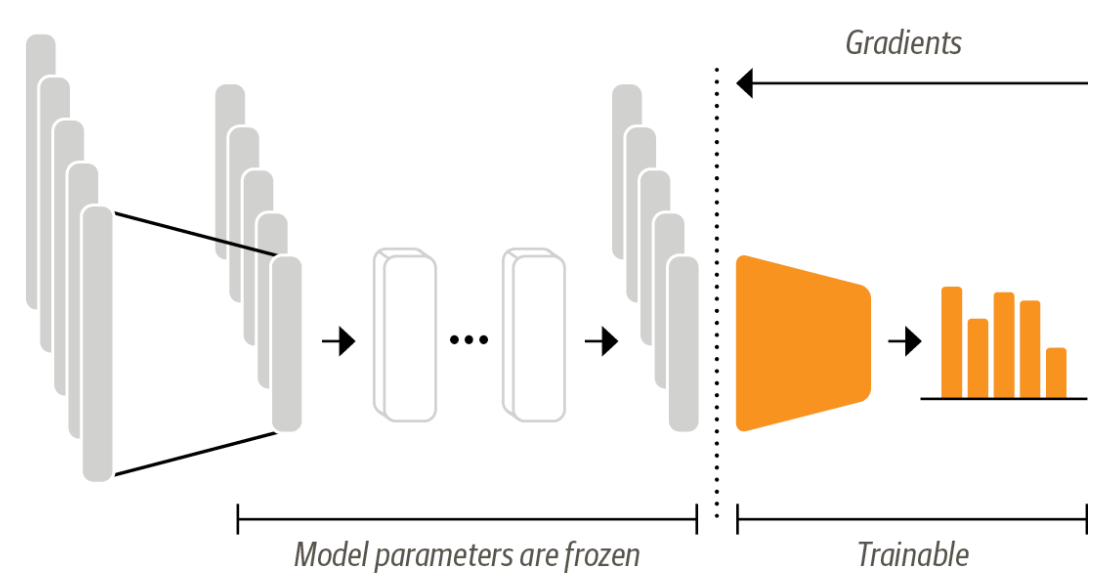

### 사전 훈련된 모델 사용하기
##### AutoModel 클래스는 사전 훈련된 모델의 가중치를 로드하는 from_pretrained() 메서드가 있다. 해당 메서드를 사용하여 DistilBERT의 체크포인트를 로드한다.

In [40]:
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

##### AutoModel 클래스는 토큰 인코딩을 임베딩으로 변환한 다음 인코더 스택에 통과시켜 은닉 상태를 반환한다. 말뭉치에서 이런 상태를 어떻게 추출하는지 확인해보자.

### 마지막 은닉 상태 추출하기
##### 일단 하나의 문자열에 대해서 마지막 은닉 상태를 추출해보자. 우선 문자열을 인코딩하고 토큰을 파이토치 텐서로 변환한다. return_tensors="pt"로 텐서로 반환되게 한다.

In [41]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"입력 텐서의 크기 : {inputs['input_ids'].size()}")

입력 텐서의 크기 : torch.Size([1, 6])


##### 결과 텐서의 크기는 [batch_size, n_tokens]이다. 인코딩을 텐서로 준비했으니, 마지막 단계로 이를 모델이 있는 장치로 옮기고 입력으로 전달한다.

In [42]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
  outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ...,
-0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


##### gradient 자동 계산을 비활성화하기 위해 torch.no_grad()를 사용했다. 이렇게 하면 계산에 필요한 메모리 양이 줄어 추론할 때 유리하다.
##### 출력은 모델 설정에 따라 은닉 상태, 손실, 어텐션 같은 여러 객체를 포함한다. 지금 해당 모델은 마지막 은닉 상태 하나만 반환한다.

In [43]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

##### 은닉 상태 텐서의 크기는 [batch_size, n_tokens, hidden_dim] 이다. 즉 6개의 입력 토큰마다 768차원의 벡터가 반환된다.
##### 분류 작업에서는 보통 [CLS] 토큰에 연관된 은닉 상태를 입력 특성으로 사용한다. 이 토큰은 시퀀스 시작에 등장하므로 인덱스를 지정해 추출한다.

In [44]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

##### 문자열의 마지막 은닉 상태를 얻는 방법을 알았다.
##### 이제 전체 데이터셋에 같은 작업을 수행하고 hidden_state 열을 만들어 이런 벡터를 모두 저장하자.

In [45]:
def extract_hidden_states(batch):
    # 모델 입력을 GPU로 옮깁니다.
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    # 마지막 은닉 상태를 추출합니다.
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # [CLS] 토큰에 대한 벡터를 반환합니다.
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

##### 해당 모델은 텐서가 입력되길 기대하므로, input_ids와 attention_mask 열을 "torch" 포맷으로 바꾼다.

In [46]:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

##### 그리고 모든 분할에 대해 은닉 상태를 한 번에 추출하자.

In [47]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

##### batch_size=None으로 지정하지 않았기 때문에 기본 값인 1000으로 사용된다. 해당 결과로는 emotions_hidden의 열에 새로운 hidden_state 열이 데이터 셋에 추가된다.

In [48]:
emotions_hidden['train'].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

##### 이제 각 트윗에 대한 은닉 상태를 얻었으니, 다음으로 분류 모델을 훈련하자. 그렇게 하기 위해서 특성 행렬이 필요하다.

### 특성 행렬 만들기
##### 전처리 된 데이터셋에서 은닉 상태를 입력으로 사용하고 레이블을 타깃으로 사용하자.

In [49]:
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

### 훈련 세트 시각화하기
##### 768차원의 은닉 상태를 시각화하기 어렵기 때문에 UMAP 알고리즘을 사용해서 이 벡터를 2D로 투영화하자. UMAP은 특성이 [0,1] 일 때 잘 동작한다.
##### 따라서 먼저 사이킷런의 MinMaxScaler를 적용한 후 umap-learn 라이브러리의 UMAP 구현으로 은닉 상태의 차원을 축소한다.

In [50]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# 특성 스케일을 [0,1] 범위로 조정합니다.
X_scaled = MinMaxScaler().fit_transform(X_train)
# UMAP 객체를 생성하고 훈련시킵니다.
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# 2D 임베딩의 데이터프레임을 만듭니다.
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,4.059298,6.656940,0
1,-3.157836,5.729935,0
2,5.206277,3.217097,3
3,-2.570655,3.551202,2
4,-3.328499,3.773714,3


##### 출력 결과는 훈련 샘플과 개수가 동일한 배열이다. 하지만 특성은 768이 아니고 압축된 2개이다. 각 범주에 대해 샘플의 밀도를 개별로 그려보자.

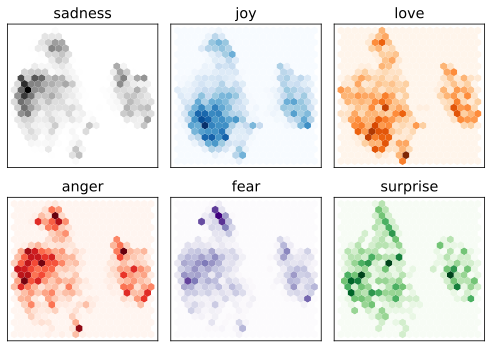

In [51]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

### 간단한 분류 모델 훈련하기
##### 위 결과를 보먄, 은닉 상태가 감정별로 조금씩 다르지만 일부 감정 사이에는 명확한 경계가 없기도 하다. 이 은닉 상태를 사용해 사이킷런의 로지스틱 회귀 모델을 훈련한다.

In [52]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.6335

In [53]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

##### 따라서 DistilBERT 임베딩을 사용한 간단한 분류 모델은 기준 모델보다 훨씬 더 뛰어나다.
##### 분류 모델의 성능을 자세하게 조사하기 위해 오차 행렬을 살펴보자.

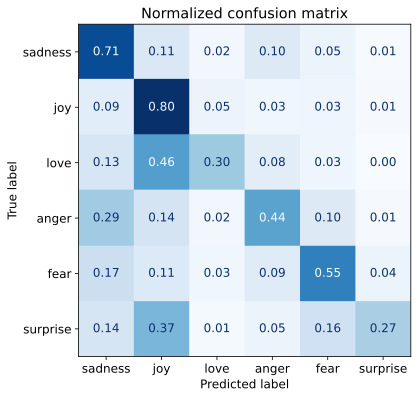

In [54]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

##### 결과를 보면 anger와 fear는 sadness와 가장 많이 혼동된다. 또 love와 surprise는 joy와 많이 혼동된다.
##### 분류 성능을 높이기 위해 미세 튜닝을 다음 절에서 해보자. 하지만 GPU 같은 계산 자원이 더 필요하다.

### 2.3.2 트랜스포머 미세 튜닝하기
##### 미세 튜닝 방식에서는 은닉 상태를 고정된 특성으로 사용하지 않고 아래와 같이 전체 모델을 튜닝한데.
##### 이를 위해 분류 헤드는 미분 가능해야 한다. 따라서 이 방식은 일반적으로 신경망으로 분류 작업을 수행한다.
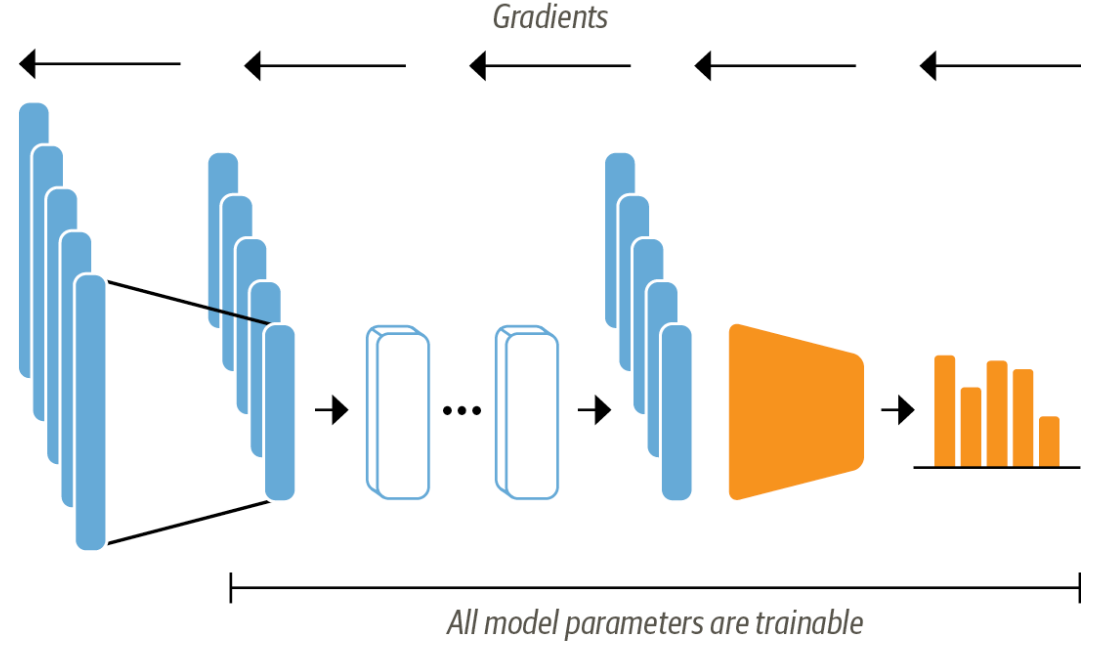

##### 트랜스포머스의 Trainer API를 사용해 룬련 루프를 간단하게 구현해보자.

### 사전 훈련된 모델 로드하기
##### AutoModel 클래스 대신 AutoModelForSequenceClassification을 사용한다. 그것은 사전 훈련된 모델 출력 위에 베이스 모델과 함께 쉽게 훈련할 수 있는 분류 헤드가 있다.
##### 여기서는 분류 헤드의 크기를 설정하기 위해 모델이 예측할 레이블 개수를 지정한다.

In [55]:
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

### 성공 지표 정의하기
##### 훈련하는 동안 성능을 모니터링하기 위해 Trainer에 사용할 compute_metrics() 함수를 정의한다. 해당 함수는 EvalPrediction 객체를 입력받아 측정 지표 이름과 값을 매핑한 딕셔너리를 반환한다.

In [56]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

##### 데이터셋과 측정 지표가 준비되면 Trainer 클래스를 정의하기 전 두 가지를 처리해야한다.
1. 허깅페이스 허브에 로그인하여 미세 튜닝한 모델을 허브 계정에 저장하고 커뮤니티에 공유한다.
2. 훈련을 위한 모든 하이퍼파라미터를 정의한다.

### 모델 훈련하기

In [57]:
from huggingface_hub import notebook_login

notebook_login()

##### 훈련 파라미터를 정의하기 위해 TrainingArguments 파라미터를 사용한다. 해당 클래스는 많은 정보를 저장하며 훈련과 평가를 상세하게 제어한다. 가장 중요한 매개변수는 훈련 과정에서 생성된 부산물이 저장될 output_dir이다.

In [58]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  save_strategy="epoch",
                                  load_best_model_at_end=True,
                                  log_level="error")

##### 배치 크기, 학습률, 에포크 횟수도 설정하고 훈련이 끝난 후 최상의 모델을 로드하도록 지정했다. 이런 설정으로 Trainer 객체를 만들고 모델을 미세 튜닝한다.

In [59]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.815900,0.321286,0.907000,0.906414
2,0.247900,0.215793,0.925000,0.925033


TrainOutput(global_step=500, training_loss=0.5318976058959961, metrics={'train_runtime': 238.9624, 'train_samples_per_second': 133.912, 'train_steps_per_second': 2.092, 'total_flos': 720342861696000.0, 'train_loss': 0.5318976058959961, 'epoch': 2.0})

##### 특성 기반 방식보다 매우 많이 향상되었다.
##### 오차 행렬을 만들어 훈련 결과를 더 상세히 살펴보자. 오차 행렬을 만들기 위해서 먼저 검증 세트에 대한 예측을 만든다. Trainer 클래스의 predict() 메서드는 평가에 사용할 수 있는 유용한 객체를 반환한다.

In [60]:
preds_output = trainer.predict(emotions_encoded["validation"])
preds_output.metrics

{'test_loss': 0.2157929688692093,
 'test_accuracy': 0.925,
 'test_f1': 0.9250328768746947,
 'test_runtime': 4.0726,
 'test_samples_per_second': 491.093,
 'test_steps_per_second': 7.857}

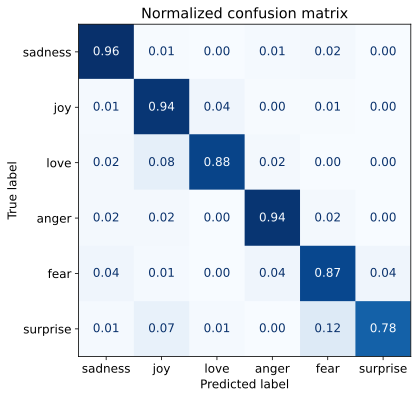

In [61]:
y_preds = np.argmax(preds_output.predictions, axis=1)
plot_confusion_matrix(y_preds, y_valid, labels)

##### 해당 오차 행렬은 주대각선 원소 외에는 거의 0에 가까워 매우 이상적이다.
##### 여기서 마무리하기 전에 모델이 일으킬 가능성이 있는 오류 유형에 대해서 자세히 분석해보자

### 오류 분석


##### 모델의 예측에 대해서 자세히 보면, 모델의 손실 기준으로 검증 샘플을 정렬하는 방법이 있다.
##### 정방향 패스의 결과와 레이블을 사용하면 손실은 자동으로 계산할 수 있다. 아래에 손실과 예측 레이블을 반환하는 함수이다.

In [62]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # 모든 입력 텐서를 모델과 같은 장치로 이동합니다.
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")

    # 다른 데이터셋 열과 호환되도록 출력을 CPU로 옮깁니다.
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

In [63]:
# 데이터셋을 다시 파이토치 텐서로 변환합니다.
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])
# 손실 값을 계산합니다.
emotions_encoded["validation"] = emotions_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [64]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

##### 이제 emotions_encoded를 손실 기준으로 오름차순이나 내림차순으로 정렬할 수 있다. 해당 작업은 아래와 같은 상황을 감지할 수 있다.

#### 잘못된 레이블
##### 데이터에 레이블을 부여하는 프로세스는 완벽하지 않다. 앞에서와 같은 방식을 사용하면 이런 잘못된 레이블을 빠르게 찾아 수정할 수 있다.

#### 데이터셋의 특이사항
##### 실세계의 데이터셋은 엉성하다. 텍스트 데이터에는 특수 문자나 문자열이 포함되어 있다. 모델의 가장 나쁜 예측을 보면 이런 특성들을 찾을 수 있고, 데이터를 정제하거나 비슷한 샘플을 추가하면 모델이 안정된다.
##### 먼저 손실이 가장 높은 데이터를 확인해보자.

In [66]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1963,i called myself pro life and voted for perry w...,joy,sadness,5.653169
1870,i guess i feel betrayed because i admired him ...,joy,sadness,5.525828
1950,i as representative of everything thats wrong ...,surprise,sadness,5.488802
1274,i am going to several holiday parties and i ca...,joy,sadness,4.973522
1509,i guess this is a memoir so it feels like that...,joy,fear,4.816683
1111,im lazy my characters fall into categories of ...,joy,fear,4.756121
1500,i guess we would naturally feel a sense of lon...,anger,sadness,4.715721
1801,i feel that he was being overshadowed by the s...,love,sadness,4.693518
1964,i feel vaguely cheated and a little amused,joy,anger,4.639958
765,i feel super awkward and out of place right now,joy,sadness,4.573217


##### 모델이 일부 레이블을 잘못 예측한 것을 볼 수 있다. 반명 명확한 클래스를 부여하기 어려운 샘플도 존재한다. 이런 데이터셋을 정제하면, 데이터를 더 모으거나 더 큰 모델을 사용하는 것만큼 성능이 크게 향상된다!

### 모델 저장 및 공유
##### Trainer API를 사용하면 모델의 저장과 공유가 간단해진다.

In [67]:
trainer.push_to_hub(commit_message="Training complted!")

'https://huggingface.co/cheonboy/distilbert-base-uncased-finetuned-emotion/tree/main/'

##### 미세 튜닝된 모델을 사용해 새로운 트윗에 대해 예측을 수행할 수도 있다. 모델을 허브레 업로드 했으니 pipeline() 함수를 사용할 것이다.

In [70]:
from transformers import pipeline

# `haesun`를 자신의 허브 사용자 이름으로 바꾸세요.
model_id = "cheonboy/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)

In [71]:
custom_tweet = "I saw a movie today and it was really good."
preds = classifier(custom_tweet, top_k=None)

In [72]:
preds

[{'label': 'LABEL_1', 'score': 0.9407440423965454},
 {'label': 'LABEL_0', 'score': 0.020111238583922386},
 {'label': 'LABEL_2', 'score': 0.015830736607313156},
 {'label': 'LABEL_3', 'score': 0.009616635739803314},
 {'label': 'LABEL_5', 'score': 0.008214310742914677},
 {'label': 'LABEL_4', 'score': 0.005483018700033426}]

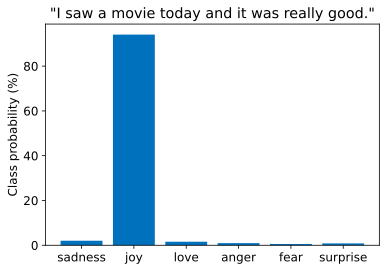

In [73]:
preds_sorted = sorted(preds, key=lambda d: d['label'])
preds_df = pd.DataFrame(preds_sorted)
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()